在spatio temporal 模型中，我们把提前训练好的embedding当作特征，嵌入到特征中作为资产的标签，让模型根据这个标签来学习资产之间的关系

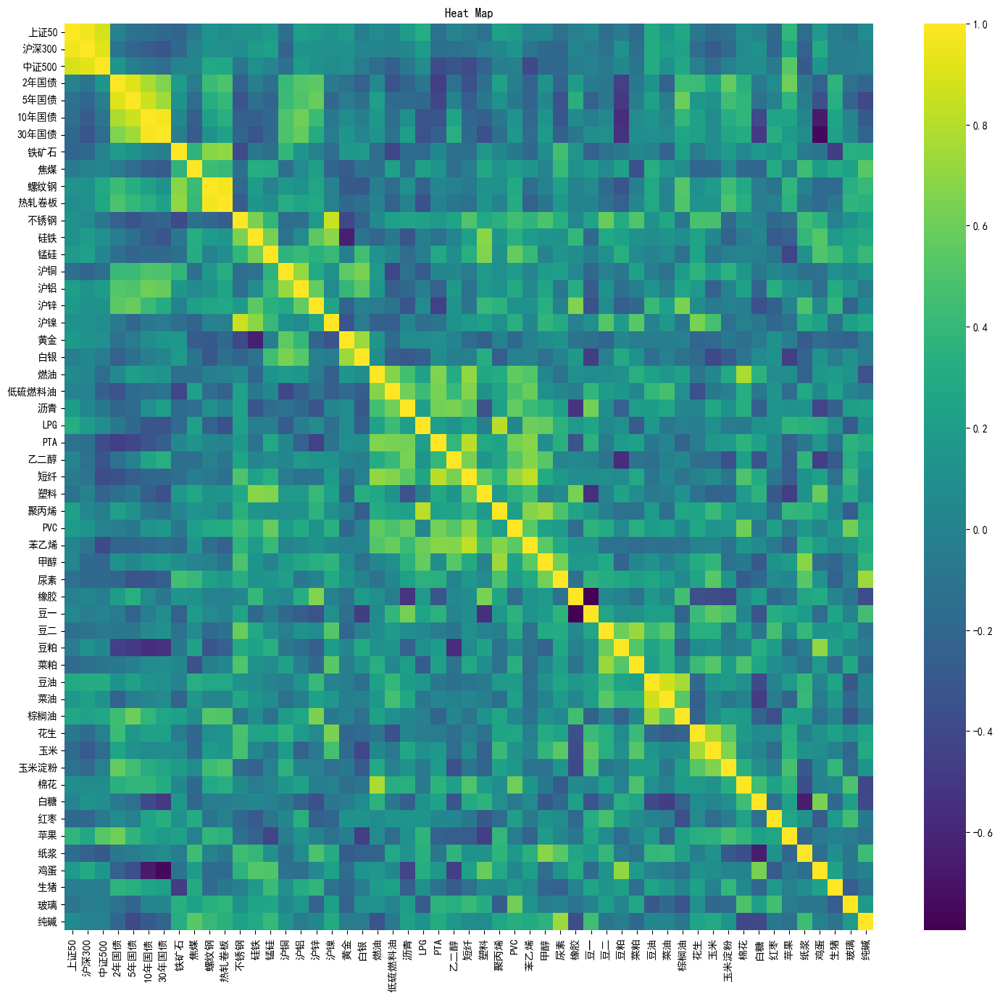

In [6]:
from PIL import Image
Image.open('output.png').resize((1000,1000))

借助图神经网络，我们可以更进一步的把这种关系应用在模型中，让Transformer模型中核心的注意力机制可以感知到我们之前预训练的这种关系，即归纳偏置；

某些资产之间有强正相关 或 强负相关，这就意味着一个资产的变动对另一个有很强的指示意义。它们之间应该有高的注意力。

而接近0的相关性如白糖与玻璃，信息价值较低，模型应该减少对它们的相互关注，避免学习到虚假的噪声。

换言之，这个embedding 实际上是一个以矩阵形式存储的资产关系图，记录着哪些资产之间有图的边，表示资产之间的相关关系。

为了进一步减少噪声，还可以设置一个阈值，将低于该阈值的弱相关性直接视为0，砍掉图之间比较弱的边，简化图结构

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class AttentionWithCosineBias(nn.Module):
    """
    将输入的资产嵌入向量的相似度作为决定资产间注意力的归纳偏置，强正相关和强负相关都会引导至强注意力
    """
    def __init__(self, dim_feature, num_head=8, alpha=1.0, threshold=0.1, dropout=0.1):
        """
        dim_feature: 输入特征的维度
        num_head: 注意力头的数量
        alpha: 控制偏置强度的超参数
        threshold: 用于稀疏化相似度矩阵的阈值
        """
        super().__init__()
        assert dim_feature % num_head == 0, "dim_feature 必须能被 num_head 整除"


        self.alpha = alpha
        self.threshold = threshold
        
        self.dim_feature = dim_feature
        self.num_head = num_head
        self.dim_head = dim_feature // num_head
        self.scale = self.dim_head ** -0.5

        # 用于生成Q, K, V的线性变换层
        self.wq = nn.Linear(dim_feature, dim_feature, bias=False)
        self.wk = nn.Linear(dim_feature, dim_feature, bias=False)
        self.wv = nn.Linear(dim_feature, dim_feature, bias=False)
        self.fc_out = nn.Linear(dim_feature, dim_feature)
        
        self.dropout = nn.Dropout(dropout)


    def _calculate_dynamic_bias(self, asset_embeddings):
        norm_embeds = F.normalize(asset_embeddings, p=2, dim=-1)
        # 计算相似度/相关性
        cosine_sim_matrix = torch.matmul(norm_embeds, norm_embeds.transpose(-2, -1))
        cosine_sim_matrix.diagonal(dim1=-2, dim2=-1).fill_(1.0)
        # 稀疏化，关闭那些关系几乎无关的相关性，对模型进行剪枝
        cosine_sim_matrix[torch.abs(cosine_sim_matrix) < self.threshold] = 0
        # 计算权重
        strength_matrix = cosine_sim_matrix ** 2
        bias = self.alpha * (strength_matrix - 1.0)
        
        return bias

    def forward(self, query, key, value, asset_embeddings, mask=None):

        batch_size = query.size(0)
        bias = self._calculate_dynamic_bias(asset_embeddings)
        # 如果bias是(S,S)而分数是(B,H,S,S), PyTorch会自动广播
        # 如果bias是(B,S,S), 需要unsqueeze(1)来匹配头的维度 -> (B,1,S,S)
        if bias.dim() == 3:
            bias = bias.unsqueeze(1)

        # 多头注意力
        Q = self.wq(query).view(batch_size, -1, self.num_head, self.dim_head).transpose(1, 2)
        K = self.wk(key).view(batch_size, -1, self.num_head, self.dim_head).transpose(1, 2)
        V = self.wv(value).view(batch_size, -1, self.num_head, self.dim_head).transpose(1, 2)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
        # 归纳偏置
        biased_scores = attention_scores + bias

        # 掩码
        if mask is not None:
            biased_scores = biased_scores.masked_fill(mask == 0, -1e9)

        # 计算注意力权重
        attention_weights = F.softmax(biased_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_feature)
        output = self.fc_out(context)

        return output, attention_weights

# --- 示例用法 ---
if __name__ == '__main__':
    num_assets = 50
    feature_dim = 128
    batch_size = 32
    num_heads = 8
    # 资产嵌入向量的维度，可以与feature_dim不同
    embedding_dim = 64

    # 1. 实例化注意力模块 (不再需要传入correlation_matrix)
    dynamic_attention_layer = AttentionWithCosineBias(
        dim_feature=feature_dim,
        num_head=num_heads,
        alpha=2.0
    )

    # 2. 创建随机输入数据
    x = torch.randn(batch_size, num_assets, feature_dim)
    q, k, v = x, x, x

    # 3. 创建资产嵌入向量
    # 在一个完整的模型中, 这通常是一个 nn.Embedding(num_assets, embedding_dim) 层的输出
    # 这里我们创建一个随机的作为示例
    # 假设所有batch共享同一套资产嵌入 (shape: S, E)
    asset_embeds = torch.randn(num_assets, embedding_dim)
    
    # 4. 前向传播，并传入资产嵌入
    output, weights = dynamic_attention_layer(q, k, v, asset_embeddings=asset_embeds)

    # 5. 检查输出形状
    print("--- 共享嵌入 (S, E) 的情况 ---")
    print(f"输入形状: {x.shape}")
    print(f"资产嵌入形状: {asset_embeds.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {weights.shape}\n")

    # 另一种情况：每个batch有自己独立的资产嵌入 (shape: B, S, E)
    # 这在某些模型设计中可能出现
    asset_embeds_batch = torch.randn(batch_size, num_assets, embedding_dim)
    output_batch, weights_batch = dynamic_attention_layer(q, k, v, asset_embeddings=asset_embeds_batch)
    print("--- 批次独立嵌入 (B, S, E) 的情况 ---")
    print(f"资产嵌入形状: {asset_embeds_batch.shape}")
    print(f"输出形状: {output_batch.shape}")
    print(f"注意力权重形状: {weights_batch.shape}")